<a href="https://colab.research.google.com/github/jiin124/2021_2_SAI_ML/blob/main/%EB%B6%84%EB%A5%98_%EB%9E%9C%EB%8D%A4%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8%2C_GBM%2C_XGBoost%2C_%EC%9C%84%EC%8A%A4%EC%BD%98%EC%8B%A0%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Activity Recognition Using Smartphones Data set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#features.txt파엘이는 피처 이름 index와 피처명이 공백으로 분리되어있다. 이를 dataframe으로 로드
feature_name_df=pd.read_csv('drive/MyDrive/human_activity/features.txt',sep='\s+',
                            header=None,names=['column_index','column_name'])

#피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name=feature_name_df.iloc[:,1].values.tolist()
print('전체 피처명에서 10개만 추출:',feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


피처명을 보면 인체의 움직임과 관련된 속성의 평균/표준편차가 X,Y,Z축 값으로 되어있음을 유추할 수 있다. 위에서 피처명을 가지고 있는 feature_info.txt는 중복된 피처명을 가지고 있다. 이 중복된 피처명들을 이용해 데이터 파일을 데이터 세트 DataFrame에서 유추하면 오류가 발생한다. 

In [2]:
feature_dup_df=feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


총 42개의 피처명이 중복돼있다. 이 중복된 피처명에 대해서는 원본 피처명에 _1,_2를 추가로 부여해 새로운 피처명을 가지를 dataframe을 반환하는 함수인 get_new_feature_name_df를 생성하겠다

In [3]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    # print(new_feature_name_df.info())
    
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    # print(new_feature_name_df.info())
    return new_feature_name_df

In [4]:
import pandas as pd

def get_human_dataset() :
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로
    # read_csv에서 공백 문자를 sep로 할당
    feature_name_df = pd.read_csv('drive/MyDrive//human_activity/features.txt', sep='\s+',
                                 header=None, names=['column_index', 'column_name'])
    new_feature_name_df=get_new_feature_name_df(feature_name_df)
    # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 세트와 테스트 피처 데이터를 DataFrame으로 로딩
    # 칼럼명은 feature_name 적용
    X_train = pd.read_csv('drive/MyDrive//human_activity/train/X_train.txt', sep = '\s+', names = feature_name)
    X_test = pd.read_csv('drive/MyDrive//human_activity/test/X_test.txt', sep = '\s+', names = feature_name )
    
    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩
    # 칼럼명은 action으로 부여
    y_train = pd.read_csv('drive/MyDrive//human_activity/train/y_train.txt', sep = '\s+', header = None, names = ['action'])
    y_test = pd.read_csv('drive/MyDrive//human_activity/test/y_test.txt', sep = '\s+', header = None, names = ['action'])
    
    # 로드된 학습/테스트용 DataFrame 모두 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [5]:
print('##학습 피처 데이터셋 info()')
print(X_train.info())

##학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [6]:
# 레이블 값은 1, 2, 3, 4, 5, 6의 6개 값이고
# 분포도는 특정 값으로 왜곡되지 않고 비교적 고르게 분포되어 있다
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#예제 반복시마다 동일한 예측 결과 도출을 위해 random_state결정
dt_clf=DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train,y_train)
pred=dt_clf.predict(X_test)
accuracy=accuracy_score(y_test,pred)
print("결정트리 예측 정확도 : {0:.4f}".format(accuracy))

#DecisionTreeClassfier의 하이퍼 파라미터 추출
print("DecisionTreeClassifier 기본 하이퍼 파라미터:\n",dt_clf.get_params())

결정트리 예측 정확도 : 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 156, 'splitter': 'best'}


약 85.48%의 정확도를 나타내고 있다. 이번에는 결정 트리의 트리 깊이가 예측 정확도에 주는 영향을 살펴보겠다. GridSearchCV를 이용해 사이킷런 결정 트리의 깊이를 조절할 수 있는 하이퍼 파라미터이 max_depth 값을 변화시키면서 예측 성능을 확인해보겠다.





In [ ]:
from sklearn.model_selection import GridSearchCV

params={'max_depth':[6,8,10,12,16,20,24]}

grid_cv=GridSearchCV(dt_clf,param_grid=params,scoring='accuracy',cv=5,verbose=1)
grid_cv.fit(X_train,y_train)
print('Gridsearch 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearch 최적 하이퍼 파라미터 :',grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: ignored

max_depth=16일때 5개의 폴드 세트의 최고 평균 정확도 결과가 85.13%로 도출됐다.
5개의 CV세트에서 max_depth 값에 따라 어떻게 예측 성능이 변했는지 GridSearchCV 객체의 cv_results_ 속성을 통해 살펴보겠다. 

In [ ]:
#GridSearCV 객체의 cv_results_ 속성을 DataFrame으로 생성.
cv_results_df=pd.DataFrame(grid_cv.cv_results_)

#max_depth 파라미터 값과 그때의 티ㅔ스트 세트 학습 데이터 세트의 정확도 수치 추출
cv_results_df[['param_max_depth','mean_test_score']]

이번에는 별도의 테스트 데이터 세트에서 결정 트리의 정확도를 측정해보겠다. 

In [ ]:
max_depth=[6,8,10,12,16,20,24]
#max_dapth값을 변화시키면서 그때마다 학습과 테스트 세트에서의 예측 성능 측정
for depth in max_depth:
  dt_clf=DecisionTreeClassifier(max_depth=depth,random_state=156)
  dt_clf.fit(X_train,y_train)
  pred=dt_clf.predict(X_test)
  accuracy=accuracy_score(y_test,pred)
  print('max_depth={0} 정확도 : {1:.4f}'.format(depth,accuracy))

8일때 가장 높은 정확도를 나타낸다. 그리고 커질수록 정확도는 낮아지고 있다. 이론이 맞군.

In [ ]:
#max_depth,min_samples_split를 같이 변경하면서 정확도 성능을 튜닝해보겠다.
params={
    'max_depth':[8,12,16,20],
    'min_samples_split':[16,24],
}

grid_cv=GridSearchCV(dt_clf,param_grid=params,scoring='accuracy',cv=5,verbose=1)
grid_cv.fit(X_train,y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:',grid_cv.best_params_)


GridSearchCV객체의 grid_cv의 속성인 best_estimator_ 는 최적 하이퍼 파라미터이 max_depth 8, min_samples_split 16으로 학습이 완료된 estimator 객체이다. 

In [ ]:
best_df_clf=grid_cv.best_estimator_
pred1=best_df_clf.predict(X_test)
accuracy=accuracy_score(y_test,pred1)
print("결정 트리 에측 정확도:{0:.4f}".format(accuracy))

In [ ]:
import seaborn as sns

ftr_importances_values=best_df_clf.feature_importances_
#Top중요도로 정렬을 쉽게 하고, 시본의 막대그래프로 ㅜ십게 표현하기 위한 series변환
ftr_importances=pd.Series(ftr_importances_values,index=X_train.columns)
#중요도값 순으로 Series값을 정렬
ftr_top20=ftr_importances.sort_values(ascending=False)[:20]
plt.title('Feature importances Top20')
sns.barplot(x=ftr_top20,y=ftr_top20.index)
plt.show()

# 랜덤 포레스트

위에서 사용한 사용자 행동 인식 데이터 세트를 그대로 사용하겠다. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#결정트리에서 사용한 get_human_dataset()을 이용해 학습.테스트용 데이터프레임 반환
X_train,X_test,y_train,y_test=get_human_dataset()

#랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf=RandomForestClassifier(random_state=0)
rf_clf.fit(X_train,y_train)
pred=rf_clf.predict(X_test)
accuracy=accuracy_score(y_test,pred)
print("랜덤 포레스트 정확도:{0:.4f}".format(accuracy))

랜덤 포레스트 정확도:0.9253


## 랜덤 포레스트 하이퍼 파라미터 및 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV

params={
    'n_estimators':[100],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}

#RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf=RandomForestClassifier(random_state=0,n_jobs=-1)
grid_cv=GridSearchCV(rf_clf,param_grid=params,cv=2,n_jobs=-1)
grid_cv.fit(X_train,y_train)

print("최적 하이퍼 파라미터: ",grid_cv.best_params_)
print("최고 예측 정확도 : ",grid_cv.best_score_)

최적 하이퍼 파라미터:  {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도 :  0.9179815016322089


이제 n_estimators를 300으로 증가시키고 최적화 하이퍼 파라미터로 다시 randomforestclasifier를 학습 스킨 뒤 이번에는 별도의 테스트 데이터 세트에서 예측 성능을 측정해보겟다.

In [ ]:
rf_clf1=RandomForestClassifier(n_estimators=300,max_depth=10,min_samples_leaf=8,
                               min_samples_split=8,random_state=0)

rf_clf1.fit(X_train,y_train)
pred=rf_clf1.predict(X_test)
print("예즉 정확도 : {0:.4f}".format(accuracy_score(y_test,pred)))

예즉 정확도 : 0.9165


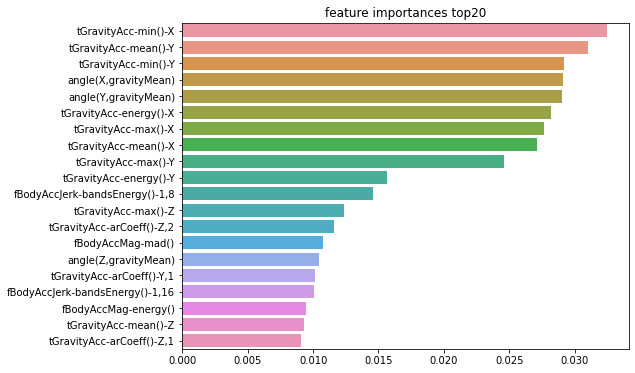

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

ftr_importances_values=rf_clf1.feature_importances_
ftr_importances=pd.Series(ftr_importances_values,index=X_train.columns)
ftr_top20=ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title("feature importances top20")
sns.barplot(x=ftr_top20,y=ftr_top20.index)
plt.show()

# GBM(Gradient Boosting Machine)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train,X_test,y_train,y_test=get_human_dataset()

#GBM 수행시간 측정을 위함. 시작 시간 설정
start_time=time.time()
gb_clf=GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train,y_train)
gb_pred=gb_clf.predict(X_test)
gb_accuracy=accuracy_score(y_test,gb_pred)

print('GBM 정확도 : {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간:{0:.1f}'.format(time.time()-start_time))

GBM 정확도 : 0.9386
GBM 수행 시간:815.4


## GBM 하이퍼 파라미터 및 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV

params={
    'n_estimators':[100,500],
    'learning_rate':[0.05,0.1]
}
grid_cv=GridSearchCV(gb_clf,param_grid=params,cv=2,verbose=1)
grid_cv.fit(X_train,y_train)
print('최적 하이퍼 파라미터 :\n',grid_cv.best_params_)
print('최고 예측 정확도 :{0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 81.3min finished


최적 하이퍼 파라미터 :
 {'learning_rate': 0.05, 'n_estimators': 500}
최고 예측 정확도 :0.9013


In [ ]:
#gridsearchcv를 이용해 최적으로 학습된 estimator로 학습 수행
gb_pred=grid_cv.best_estimator_.predict(X_test)
gb_accuracy=accuracy_score(y_test,gb_pred)
print('GBM 정확도 : {0:.4f}'.format(gb_accuracy))

GBM 정확도 : 0.9396


# XGBoost

In [ ]:
import xgboost
print(xgboost.__version__)

0.90


## 파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측

In [ ]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset=load_breast_cancer()
X_features=dataset.data
y_label=dataset.target
df=pd.DataFrame(data=X_features,columns=dataset.feature_names)
df['target']=y_label
df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [ ]:
print(dataset.target_names)
print(df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


1값인 양성benign이 357개, 0값인 양성이 malignant가 212개로 구성. 전체 데이터 세트 중 80%를 학습용으로 20%를 테스트용으로 분할해보자

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_features,y_label,test_size=0.2,random_state=156)

print(X_train.shape,X_test.shape)

(455, 30) (114, 30)


파이썬 래퍼 XGBoost는 사이킷런과 차이가 여러가지 있지만 먼저 눈에 띄는 차이는 학습용과 테스트용 데이터 세트를 ㅜ이해 별도의 객체인 DMatrix를 생성한다는 점. 입력 파라미터를 받아서 만들어지는 XGBoost만의 전용 데이터 세트. DMatrix의 주요 입력 파라미터는 data와 label이다. datasms 피처 데이터 세트이며, label은 분류의 경우에는 레이블 데이터 세트, 회귀의 경우에는 숫자형인 종속값 데이터 세트이다. 


판다스의 dataFrame으로 데이터 인터페이스를 하기 위해서는 DataFrame.values를 이용해 넘파이로 일차 변환한 뒤에 이를 이용해 DMatirx변환을 적용한다. 

In [ ]:
dtrain=xgb.DMatrix(data=X_train,label=y_train)
dtest=xgb.DMatrix(data=X_test,label=y_test)

파이썬 래퍼 XGBoost 모듈인 xgboost를 이용해 학습을 수행하기 전에 먼저 XGBoost의 하이퍼 파라미터를 설정. XGBoost의 하이퍼 파라미터는 주로 딕셔너리 형태로 입력한다. 다음과 같은 하이퍼 파라미터 설정을 딕셔너리 형태로 만들어보겠다.

- max_depth는 3
- 학습률 eta는 0.1(XGBClassifier 사용시 eta가 아니라 learning_rate)
- 예제 데이터가 0 또는 1 이진 분류이므로 목적함수는 이진 로지스틱
- 오류 함수의 평가 성능 지표는 logloss.
- num_rounds는 400회.

In [ ]:
params={
    'max_depth':3,
    'objective':'binary:logistic',
    'eval_metric':'logloss',
    'early_stopping':100
}
num_rounds=400

위에 지정된 하이퍼 파라미터로 XGBoost 모델을 학습시켜보겠다. 파이썬 래퍼 XGBoost는 하이퍼 파라미터를 xgboost 모듈의 train()함수에 파라미터로 전달.그리고 학습 시 XGBoost는 수행 속도를 개선하기 위해 조기중단 기능을 제공한다. 저이상 지표 개선이 없을 경우 num_boost_round 횟수를 모두 채우지 않고 중간에 반복 탈출!

조기 중단은 xgboost()의 train()함수에 early_stopping_rounds 파라미터를 입력해 설정한다. 여기서는 조기중단 할 수 있는 최소 반복횟수를 100으로 설정하겠다. early_stopping_rounds 파라미터를 설정해 조기 중단을 수행하기 ㅜ이해서는 반드시 eval_set과 eval_metric이 함께 설정돼야 한다. 

- eval_set은 성능 평가를 수행할 평가용 데이터 세트를 설정
- eval_metric은 평가 세트에 적용할 성능 평가 방법. 분류일 경우 주로 error. logloss 적용

In [ ]:
#train 데이터 세트는 'train','evaluation(test) 데이터 세트는 'eval'로 명기
wlist=[(dtrain,'train'),(dtest,'eval')]

#하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model=xgb.train(params=params,dtrain=dtrain,num_boost_round=num_rounds,
                    early_stopping_rounds=100,evals=wlist)

[0]	train-logloss:0.467748	eval-logloss:0.479838
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.335779	eval-logloss:0.362179
[2]	train-logloss:0.252541	eval-logloss:0.290041
[3]	train-logloss:0.195835	eval-logloss:0.233818
[4]	train-logloss:0.156638	eval-logloss:0.199013
[5]	train-logloss:0.126627	eval-logloss:0.174692
[6]	train-logloss:0.103527	eval-logloss:0.155492
[7]	train-logloss:0.085451	eval-logloss:0.133671
[8]	train-logloss:0.072771	eval-logloss:0.124106
[9]	train-logloss:0.06333	eval-logloss:0.116106
[10]	train-logloss:0.054842	eval-logloss:0.107679
[11]	train-logloss:0.04787	eval-logloss:0.100176
[12]	train-logloss:0.043336	eval-logloss:0.097538
[13]	train-logloss:0.037944	eval-logloss:0.089204
[14]	train-logloss:0.033084	eval-logloss:0.092592
[15]	train-logloss:0.029423	eval-logloss:0.09144
[16]	train-logloss:0.026893	eval-logloss:0.090663
[17]	train-lo

train()으로 학습을 수행하면 반복시 train-error와 eval-logloss가 지속적으로 감소한다. xgboost를 이용해 모델의 학습이 완료됐으면 이를 이용해 테스트 데이터 세트에 예측을 수행해 보겠다. 파이썬 래퍼 XGBoost는 train()함수를 호출해 학습이 완료된 모델 객체를 반환하게 되는데 이 모델 객체는 예측을 위해 predict()메서드를 이용한다. 하낙지 유의할 점은 사이킷런의 predict()메서드는 예측 결과 클래스 값을 반환하는데 반해 xgboost의 predict()는 예측 결괏값이 아닌 예측 결과를 추정할 수 있는 확률 값을 반환한다는 것. 

In [ ]:
pred_probs=xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10],3))

#예측 확률이 0.5보다 크면 1 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds=[1 if x> 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:',preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.978 0.004 0.945 0.054 0.994 1.    1.    1.    0.998 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


### get_clf_eval 함수

In [10]:
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.metrics import recall_score,f1_score,roc_auc_score
import numpy as np 

#3장 평가에서 생성한 get_clf_eval() 함수를 적용해 XGBoost 모델의 예측 성능 평가
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'
          .format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
get_clf_eval(y_test,preds,pred_probs)

오차행렬
[[35  2]
 [ 2 75]]
정확도: 0.9649, 정밀도: 0.9740, 재현율: 0.9740, F1: 0.9740, AUC:0.9600


xgboost의 plot_importance() API는 피처의 중요도를 막대그래프 형식으로 나타낸다. 기본 평가 지표로 f1스코어를 기반으로 해. 각 피처의 중요도를 나타낸다. 사이킷런은 estimator 객체의 feature_importances_ 속성을 이용해 직접 시각화 코드를 작성해야 하지만, xgboost 패키지는 plot_importance()를 이용해 바로 피처 중요도를 시각화 할 수 있다. 

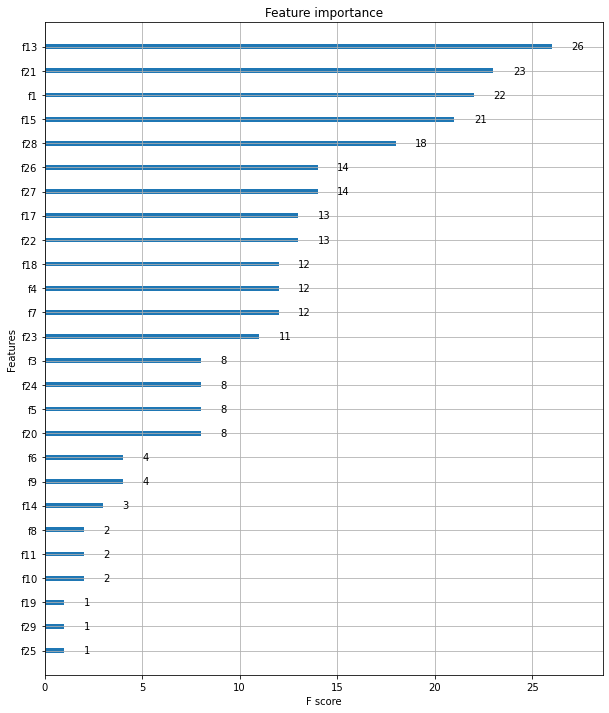

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,12))
plot_importance(xgb_model,ax=ax)

결정 트리에서 보여준 트리 기반 규칙 구조도 xgboost에서 시각화 할 수있다. xgboost 모듈의 to_graphviz() api를 사용하면 규칙 트리 구조를 그릴 수 있다. 

파이썬 래퍼 XGBoost는 사이킷런의 GridSearchCV와 유사하게 데이터 세트에 대한 교차검증 수행 후 최적 파라미터를 구할 수 있는 방법을 cv() API로 제공한다 다음은 cv() API와 파라미터에 대한 설명이다. 

In [ ]:
import xgboost
xgboost.cv(params,dtrain,num_boost_round=10,nfold=3,stratified=False,folds=None,metrics=(),
           obj=None,feval=None,maximize=False,early_stopping_rounds=None,fpreproc=None,as_pandas=True,
           verbose_eval=None,show_stdv=True,seed=0,callbacks=None,shuffle=True)

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.468418,0.000257,0.490195,0.014758
1,0.340793,0.001526,0.377599,0.024800
2,0.256848,0.001486,0.303257,0.025145
3,0.199311,0.001673,0.256776,0.028100
4,0.156828,0.001784,0.218177,0.029447
5,0.127419,0.002107,0.189770,0.029011
6,0.104244,0.003074,0.172812,0.031871
7,0.087405,0.002183,0.159882,0.029809
8,0.074736,0.002176,0.151109,0.033181
9,0.063295,0.001491,0.144458,0.032823


cv() API와 파라미터에 대한 설명

- params(dict) : 부스터 파라미터
- dtrain(DMatrix) : 학습 데이터
- num_boost_round (int) : 부스팅 반복 횟수
- nfold (int) : CV 폴드 개수
- stratified (bool) : CV 수행 시 층화 표본 추출(stratified sampling) 수행 여부
- metrics string or list of strings) : CV 수행 시 모니터링할 성능 평가 지표
- early_stopping_rounds (int) : 조기중단을 활성화 시킴. 반복 획수 지정. 


xgb.cv의 반환 값은 DataFrame 형태이다. 이쯤에서 파이썬 래퍼 XGBoost 모듈에대한 소개와 사용법을 마친다. 

## 사이킷런 래퍼 XGBoost의 개요 및 적용

In [ ]:
#사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400,learning_rate=0.1,max_depth=3)
xgb_wrapper.fit(X_train,y_train)
w_preds=xgb_wrapper.predict(X_test)
w_preds_proba=xgb_wrapper.predict_proba(X_test)[:,1]

In [ ]:
get_clf_eval(y_test,w_preds,w_preds_proba)

오차행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC:0.9665


In [ ]:
from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400,learning_rate=0.1,max_depth=3)
evals=[(X_test,y_test)]
xgb_wrapper.fit(X_train,y_train,early_stopping_rounds=100,eval_metric="logloss",
                eval_set=evals,verbose=True)
ws100_preds=xgb_wrapper.predict(X_test)
ws100_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

In [ ]:
get_clf_eval(y_test,ws100_preds,ws100_pred_proba)

오차행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC:0.9530


In [ ]:
#early_stopping_rounds=를 10으로 설정하고 재 학습
xgb_wrapper.fit(X_train,y_train,early_stopping_rounds=10,
                eval_metric="logloss",eval_set=evals,verbose=True)

ws10_pred=xgb_wrapper.predict(X_test)
ws10_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test,ws10_pred,ws100_pred_proba)

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912


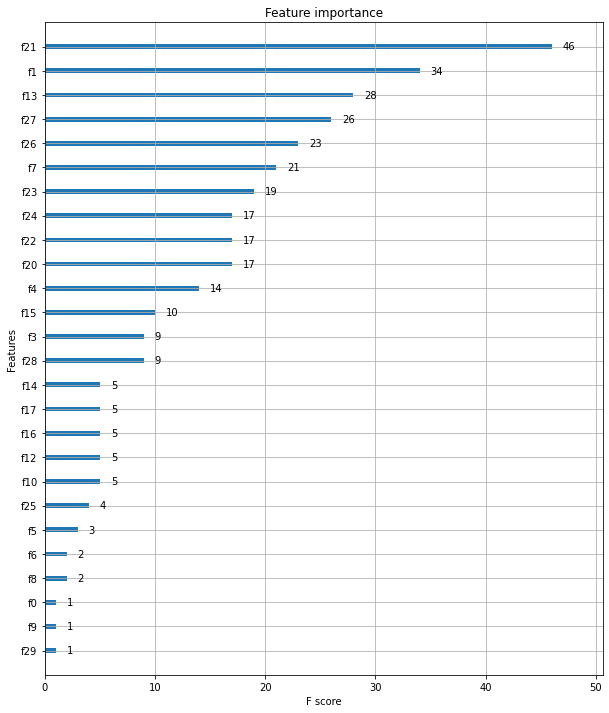

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,12))
#사이킷런 Wrapper 클래스를 입력해도 무방
plot_importance(xgb_wrapper,ax=ax)

In [ ]:
xgb_wrapper.feature_importances_

array([1.6616491e-03, 1.6631652e-02, 0.0000000e+00, 1.4326959e-02,
       6.3833855e-03, 2.2605326e-02, 4.8089591e-03, 8.7997660e-02,
       3.1706042e-04, 4.1436418e-03, 1.0341608e-02, 0.0000000e+00,
       8.5010994e-03, 1.2317199e-02, 8.9769587e-03, 7.9138251e-03,
       1.4635175e-02, 1.0357724e-02, 0.0000000e+00, 0.0000000e+00,
       3.6077222e-01, 1.5455114e-02, 2.3903282e-01, 4.5287434e-02,
       1.0665275e-02, 9.4822468e-03, 1.4726046e-02, 6.3845336e-02,
       5.2984236e-03, 3.5153364e-03], dtype=float32)

# LightGBM


## 위스콘신 유방암 예측

In [9]:
#LightGBM 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset=load_breast_cancer()
ftr=dataset.data
target=dataset.target

#전체 데이터 중 80%는 학습, 20%는 테스트 데이터
X_train,X_test,y_train,y_test=train_test_split(ftr,target,test_size=0.2,random_state=156)

#앞서 XGBoost와 동일하게 n_estimators 는 400 설정. 
lgbm_wrapper=LGBMClassifier(n_estimators=400)

#LightGBM도 XGBoost와 동일하게 조기중단 수행 가능
evals=[(X_test,y_test)]
lgbm_wrapper.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='logloss',
                 eval_set=evals,verbose=True)
preds=lgbm_wrapper.predict(X_test)
pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.565079	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.507451	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355846	valid_0's binary_logloss: 0.355846
[7]	valid_0's binary_logloss: 0.330897	valid_0's binary_logloss: 0.330897
[8]	valid_0's binary_logloss: 0.306923	valid_0's binary_logloss: 0.306923
[9]	valid_0's binary_logloss: 0.28776	valid_0's binary_logloss: 0.28776
[10]	valid_0's binary_logloss: 0.26917	valid_0's binary_logloss: 0.26917
[11]	valid_0's binary_logloss: 0.250954	valid_0's binary_logloss: 0.250954
[12]	valid_0's binary_logloss: 0.23847	valid_0's binary_logloss: 0.23847
[13]	valid_0's binary_logloss: 0.225865	valid_0's bi

In [11]:
get_clf_eval(y_test,preds,pred_proba)

오차행렬
[[33  4]
 [ 2 75]]
정확도: 0.9474, 정밀도: 0.9494, 재현율: 0.9740, F1: 0.9615, AUC:0.9330


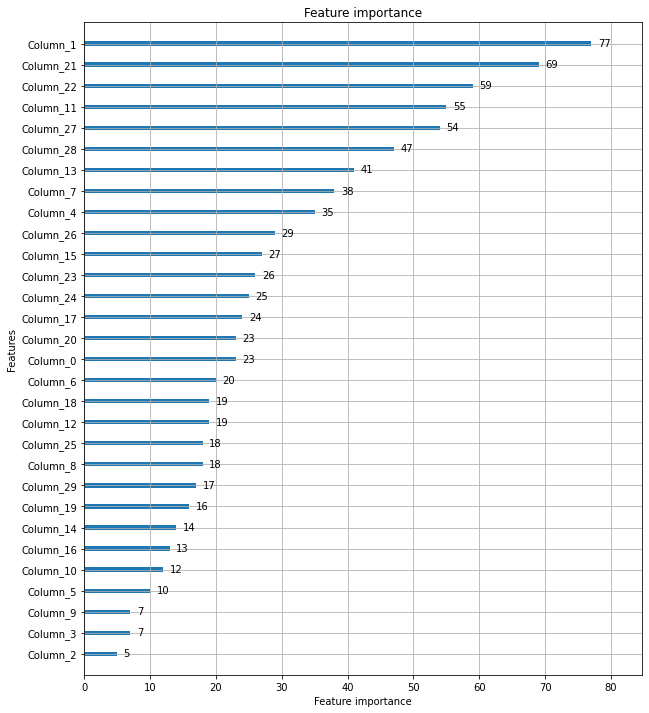

In [12]:
#plot_importance()를 이용해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper,ax=ax)